## Setup

Add logging to the notebook
Import TensorFlow and Numpy

In [ ]:
import logging
logging.getLogger("tensorflow").setLevel(logging.DEBUG)

import tensorflow as tf
import numpy as np

## Create TensorFlow Model non Quantized

TensorFlow Model same as target implemented on FPGA.
Property of model:
1. Input: 28x28x1
2. Conv1: 12 filters, 3x3x1, Activation: ReLU
3. Conv2: 12 filters, 3x3x1, Activation: ReLU (Optional. Only used when variation of conv layer is implemented)
4. MaxPool: 2x2
5. Output: 10

In [ ]:
# Load MNIST dataset
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the input
train_images = train_images.astype(np.float32) / 255.0
test_images = test_images.astype(np.float32) / 255.0

# Define the model architecture
model = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(28, 28)),
  tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
  tf.keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(10)
])

# Train the digit classification model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(
                  from_logits=True),
              metrics=['accuracy'])
model.fit(
  train_images,
  train_labels,
  epochs=5,
  validation_data=(test_images, test_labels)
)

11493376/11490434 [==============================] - 0s 0us/step
Epoch 1/5
1875/1875 [==============================] - 20s 11ms/step - loss: 0.2932 - accuracy: 0.9177 - val_loss: 0.1398 - val_accuracy: 0.9605
Epoch 2/5
1875/1875 [==============================] - 20s 11ms/step - loss: 0.1184 - accuracy: 0.9671 - val_loss: 0.0897 - val_accuracy: 0.9731
Epoch 3/5
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0849 - accuracy: 0.9747 - val_loss: 0.0718 - val_accuracy: 0.9776
Epoch 4/5
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0689 - accuracy: 0.9799 - val_loss: 0.0665 - val_accuracy: 0.9782
Epoch 5/5
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0598 - accuracy: 0.9823 - val_loss: 0.0588 - val_accuracy: 0.9804


## Convert to a TensorFlow Lite model

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpccirp070/assets


Changed to TensorFlow Lite model, but still using 32-bit float values for all parameter data.
Need to quantize the weights and input.

### Quantized Weights

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp2lrhuvhg/assets


INFO:tensorflow:Assets written to: /tmp/tmp2lrhuvhg/assets


### Quantized Inputs

In [ ]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(train_images).batch(1).take(100):
    # Model has only one input so each data point has one element.
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmph99qyuic/assets


INFO:tensorflow:Assets written to: /tmp/tmph99qyuic/assets


In [ ]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.float32'>
output:  <class 'numpy.float32'>


Weighs and Input are quantized.
But operation still using 32-bit float values.
Need to change to 8-bit quantized values to work on the device.

### Convert to integer-only quantization

Convert model so that all weights and inputs are quantized to 8-bit values.
All operation are quantized to 8-bit values too.
If cannot change to integer, throw error.

In [ ]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(train_images).batch(1).take(100):
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp5mtmg3qj/assets


INFO:tensorflow:Assets written to: /tmp/tmp5mtmg3qj/assets


In [ ]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


### Save the models as files

In [ ]:
import pathlib

tflite_models_dir = pathlib.Path("/tmp/mnist_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

# Save the unquantized/float model:
tflite_model_file = tflite_models_dir/"mnist_model.tflite"
tflite_model_file.write_bytes(tflite_model)
# Save the quantized model:
tflite_model_quant_file = tflite_models_dir/"mnist_model_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_model_quant)

24720

## Run the TensorFlow Lite models

Do a testing on model to get accuracy.
Testing done in non-quantized model and quantized model to compare the accuracy.

In [ ]:
# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, test_image_indices):
  global test_images

  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  predictions = np.zeros((len(test_image_indices),), dtype=int)
  for i, test_image_index in enumerate(test_image_indices):
    test_image = test_images[test_image_index]
    test_label = test_labels[test_image_index]

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point

    test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]

    predictions[i] = output.argmax()

  return predictions


### Test the models 


First, test with one image to see if the model is working on both side.
In this test we used visualization to check the data itself.

In [ ]:
import matplotlib.pylab as plt

# Test only on one image
test_image_index = 1

## Helper function to test the models on one image
def test_model(tflite_file, test_image_index, model_type):
  global test_labels

  predictions = run_tflite_model(tflite_file, [test_image_index])

  plt.imshow(test_images[test_image_index])
  template = model_type + " Model \n True:{true}, Predicted:{predict}"
  _ = plt.title(template.format(true= str(test_labels[test_image_index]), predict=str(predictions[0])))
  plt.grid(False)

Test on Non-Quantized Model

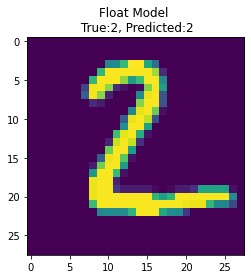

In [ ]:
test_model(tflite_model_file, test_image_index, model_type="Float")

Test on Quantized Model

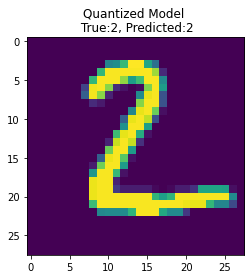

In [ ]:
test_model(tflite_model_quant_file, test_image_index, model_type="Quantized")

### Evaluate the models on all images to get accuracy

Do all round test with test data to get accuracy in non training data set.
Model accuracy is calculated by comparing the accuracy of non-quantized model and quantized model.

In [ ]:
# Helper function to evaluate a TFLite model on all images
def evaluate_model(tflite_file, model_type):
  global test_images
  global test_labels

  test_image_indices = range(test_images.shape[0])
  predictions = run_tflite_model(tflite_file, test_image_indices)

  accuracy = (np.sum(test_labels== predictions) * 100) / len(test_images)

  print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (
      model_type, accuracy, len(test_images)))

Evaluate Non-Quantized Model

In [ ]:
evaluate_model(tflite_model_file, model_type="Float")

Float model accuracy is 98.0400% (Number of test samples=10000)


Evaluate Quantized Model

In [ ]:
evaluate_model(tflite_model_quant_file, model_type="Quantized")

Quantized model accuracy is 98.0300% (Number of test samples=10000)
